In [260]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import networkx as nx

Сначала опишем структуру, которая позволяет описать состояние игры в какой-то момент времени

In [171]:
class state:
    def __init__(self, n_disk, n_tower):
        self.state = [[] for _ in range(n_tower)]
        self.n_disk = n_disk
        self.n_tower = n_tower
        
    def copy(self):
        result = state(self.n_disk, self.n_tower)
        result.state = copy.deepcopy(self.state)
        return result
        
    def hashable_repr(self):
        result = tuple(tuple(e) for e in self.state)
        return result
    
    def init_state(n_disk, n_tower):
        result = state(n_disk, n_tower)
        result.state[0] = list(np.arange(n_disk) + 1)[::-1]
        return result
        
    def final_state(n_disk, n_tower):
        result = state(n_disk, n_tower)
        result.state[-1] = list(np.arange(n_disk) + 1)[::-1]
        return result

Рекурсивная функция, которая позволяет обходить все состояния игры доступные от начального. (и параллельно строить граф) 

In [172]:
def build_graph(current_state, first_free_number, n_disk, n_tower, state_number, graph):
    for tower_idx in range(n_tower):
        if current_state.state[tower_idx]:
            last_disk = current_state.state[tower_idx][-1]
            for rhs_idx in range(n_tower):
                if rhs_idx == tower_idx:
                    continue
                if (current_state.state[rhs_idx] and current_state.state[rhs_idx][-1] > last_disk) or \
                   (not current_state.state[rhs_idx]):
                    new_state = current_state.copy()
                    new_state.state[rhs_idx].append(new_state.state[tower_idx].pop())
                    if new_state.hashable_repr() not in state_number:
                        state_number[new_state.hashable_repr()] = first_free_number[0]
                        first_free_number[0] += 1    
                        build_graph(new_state, first_free_number, n_disk, n_tower, state_number, graph)
                    
                    v = state_number[current_state.hashable_repr()]
                    u = state_number[new_state.hashable_repr()]
                    graph[v].append(u)
                        
                    
        

In [173]:
def build_tree_of_states(n_disk, n_tower):
    init_state = state(n_disk, n_tower)
    init_state.state[0] = list((np.arange(n_disk) + 1)[::-1])
    state_number = dict()
    graph = [[] for _ in range(2 ** (2 * n_disk) - 1)]    
    state_number[init_state.hashable_repr()] = 0
    
    result = build_graph(init_state, [1], n_disk, n_tower, state_number, graph)
    mapping_from_state_to_number = state_number
    
    return graph, mapping_from_state_to_number

Намалюйте дерево пошуку, де вузли - це всі стани, яких можна досягти з початкового стану, а ребра представляють дозволені переходи (переміщення) між ними.

Стоит заметить, что граф полученный таким способом деревом не является так как он содержит цикла. Но поиски в глубину и ширину помогут нам получить деревья обхода этого графа.

Получим граф состояние игры

In [174]:
n_disk, n_tower = 3, 3
states_graph, mapping_from_state_to_number = build_tree_of_states(n_disk, n_tower)

In [175]:
def adj_list_to_adj_matrix(adj_list, n_vertex):
    adj_matrix = np.zeros((n_vertex, n_vertex))
    for i in range(len(adj_list)):
        if adj_list[i]:
            for j in range(len(adj_list[i])):
                adj_matrix[i][adj_list[i][j]] = 1
    
    return adj_matrix

In [176]:
n_vertex = len(mapping_from_state_to_number.keys())
adj = adj_list_to_adj_matrix(states_graph, n_vertex)

In [177]:
init_state = state.init_state(n_disk, n_tower)
final_state = state.final_state(n_disk, n_tower)
init_state_number = mapping_from_state_to_number[init_state.hashable_repr()]
final_state_number = mapping_from_state_to_number[final_state.hashable_repr()]

In [190]:
num_to_label = lambda x: 'S' if x == init_state_number else 'F' if x == final_state_number else x

In [191]:
labels = {e:num_to_label(e) for e in range(n_vertex)}

In [196]:
num_to_color = lambda x: 'red' if x == init_state_number else 'black' if x == final_state_number else 'white'

In [197]:
color_map = [num_to_color(e) for e in range(n_vertex)]

In [198]:
def show_graph_with_labels(adjacency_matrix, mylabels, color_map):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=200, labels=mylabels, with_labels=True, node_color=color_map)
    plt.show()


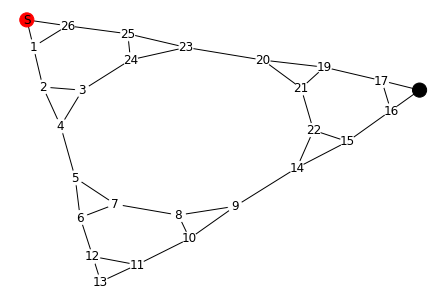

In [202]:
show_graph_with_labels(adj, labels, color_map)

Выше мы построили граф нашей игры, где вершины являются неким состояние игры, и между вершина есть ребро, есть из одного состояния можно перейти в другие.

Из изображения графа можно заметить, что кратчайшее расстояние между начальной и финальной верший равно 7. Что на самом деле соответствует действительности, так как известно что минимальное количесвто ходов ровно $2^{n} - 1$, где $n$ - количество дисков.

S - начальная вершина, черная вершина - конечная, остальные вершины промежуточным состояние игры, ниже приведем отображения из номера в состояние.

In [208]:
for state, number in mapping_from_state_to_number.items():
    print('number: %d state = %s' % (number, state.__repr__()))

number: 0 state = ((3, 2, 1), (), ())
number: 1 state = ((3, 2), (1,), ())
number: 2 state = ((3,), (1,), (2,))
number: 3 state = ((3, 1), (), (2,))
number: 4 state = ((3,), (), (2, 1))
number: 5 state = ((), (3,), (2, 1))
number: 6 state = ((1,), (3,), (2,))
number: 7 state = ((), (3, 1), (2,))
number: 8 state = ((2,), (3, 1), ())
number: 9 state = ((2, 1), (3,), ())
number: 10 state = ((2,), (3,), (1,))
number: 11 state = ((), (3, 2), (1,))
number: 12 state = ((1,), (3, 2), ())
number: 13 state = ((), (3, 2, 1), ())
number: 14 state = ((2, 1), (), (3,))
number: 15 state = ((2,), (1,), (3,))
number: 16 state = ((), (1,), (3, 2))
number: 17 state = ((1,), (), (3, 2))
number: 18 state = ((), (), (3, 2, 1))
number: 19 state = ((1,), (2,), (3,))
number: 20 state = ((), (2, 1), (3,))
number: 21 state = ((), (2,), (3, 1))
number: 22 state = ((2,), (), (3, 1))
number: 23 state = ((3,), (2, 1), ())
number: 24 state = ((3, 1), (2,), ())
number: 25 state = ((3,), (2,), (1,))
number: 26 state = 

Так же приведем пример расшифровки состояние

((1,), (), (3, 2)) соответствует следующему состоянию игры: на 1-ом шесте лежит самый маленький диск, 2-й шест является пустым, на 3-ем шесте лежат самый больший диск и следующий за ним по размеру.


Теперь когда мы построили граф игры и научились расшифровывать его, напишем BFS и DFS для манипуляций с ним.

In [222]:
def dfs(v, curr_dist, adj_list, used, count_step, final_state_number, dist):
    count_step[0] += 1
    if v == final_state_number:
        count_step[1] = count_step[0] 
    used[v] = True
    dist[v] = curr_dist
    for to in adj_list[v]:
        if not used[to]:
            dfs(to, curr_dist + 1, adj_list, used, count_step, final_state_number, dist)

In [292]:
def dfs_proccess(adj_list, n_vertex, init_state_number, final_state_number):
    source_vertex = 0
    dist = [0] * n_vertex
    used = [False] * n_vertex
    count_step = [0, 0]
    dfs(source_vertex, 0, adj_list, used, count_step, final_state_number, dist)
    
    return dist[final_state_number], count_step[1]

Запустим DFS, и посмотрим какова длина пути из начальной вершины в финальную, и так же увидим сколько вершины мы успели посетить в дереве обхода до этого момента.

In [293]:
distance_dfs, count_step_dfs = dfs_proccess(states_graph, n_vertex, init_state_number, final_state_number)

Теперь напишем функции для BFS

In [294]:
def bfs(init_state_number, adj_list, final_state_number, dist):
    n_vertex = len(dist)
    queue = [init_state_number]
    used = [False] * n_vertex
    
    dist[init_state_number] = 0
    used[init_state_number] = True
    
    current_count_step = 0
    count_step_when_find_final = None
    
    while queue:
        current_v = queue.pop(0)
        current_count_step += 1
        for to in adj_list[current_v]:
            if not used[to]:
                if to == final_state_number:
                    count_step_when_find_final = current_count_step
                dist[to] = dist[current_v] + 1
                used[to] = True
                queue.append(to)
    
    return dist[final_state_number], count_step_when_find_final

In [295]:
def bfs_proccess(adj_list, n_vertex, init_state_number, final_state_number):
    source_vertex = 0
    dist = [0] * n_vertex
    
    return bfs(source_vertex, adj_list, final_state_number, dist)

Запустим BFS, и посмотрим какова длина пути из начальной вершины в финальную, и так же увидим сколько вершины мы успели посетить в дереве обхода до этого момента.

In [296]:
distance_bfs, count_step_bfs = bfs_proccess(states_graph, n_vertex, init_state_number, final_state_number)

Теперь когда мы собрали информации с помощью DFS и BFS мы вправе ответить на следующие вопросы:

а) яка довжина шляху, який знаходить кожен алгоритм

Посмотрим какой путь нашел DFS и BFS

In [297]:
print('DFS path lenght = ', distance_dfs)
print('BFS path lenght = ', distance_bfs)

DFS path lenght =  14
BFS path lenght =  7


Теперь дадим обоснование этим результатам. BFS обладает свойством обнаружение крайтчайших путей в 0-1 графах, или другим словами BFS позволяет найти кратчайший путь по количесту ребер (что нам как раз и подходит). И то что BFS нашел длину пути равную 7, мы вправе считать настоящей длиной кратчайшего пути от начального к финального состоянию. Так же стоить заметить, что длина кратчайнего пути равна $2^n - 1$, где n - это количество дисков, и в нашем случае это равно 2^3 - 1 = 7, что и подтверждает частный случай корректности BFS.

DFS не обладает свойство поиска кратчайшего пути по количество ребер, и длина пути в целом зависит от порядка выбора следующей вершине в дереве обхода.

б) яка кількість станів, відвіданих під час пошуку. 


Ответ на этот вопрос зависит от понимаю его трактовки. Во время DFS и BFS мы обходим всю компоненту связнности, то есть посещаем все вершины.

Если вопрос состоит в том, сколько вершин мы успели обойти до того момента как попали в финальную вершину, то ответ на него можно получить только эмпирическим путем.

In [298]:
print('visit vertex DFS = ', count_step_dfs)
print('visit vertex BFS = ', count_step_bfs)

visit vertex DFS =  19
visit vertex BFS =  18


Как видим, перед тем как попасть в финальную вершину мы обошли примерно одинаковое количество вершин каждым из алгоритмов.

Чи залежить результат від порядку, в якому сусіди кожного вузла додаються до списку?

Результат длины пути алгоритма BFS не зависит, так как он всегда находит настоящий кратчайший путь по количеству ребер. Результат в DFS зависит, так как важно в каком направлении мы пойдем в дереве обхода.

Количество пройденных вершин, перед тем как мы попали в финальную зависит от способа обхода соседей, как в DFS, так и в DFS.

Как пример, рассмотрим граф-солнышко.

In [309]:
n_vertex_sun = 6
adj_matrix_sun = np.zeros((n_vertex_sun, n_vertex_sun))
for i in range(n_vertex_sun - 1):
    adj_matrix_sun[i + 1][0] = 1
    adj_matrix_sun[0][i + 1] = 1

In [310]:
labels = {e:e + 1 for e in np.arange(n_vertex_sun)}
color_map = ['red'] * n_vertex_sun

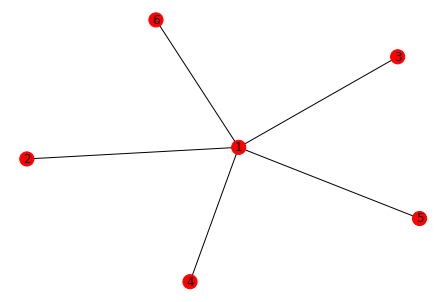

In [311]:
show_graph_with_labels(adj_matrix_sun, labels, color_map)

Пускай мы имеем такой граф как на русинке выше, и перед нами стоит задача добрать из вершины номер 1 к вершине номер 5. 

Сначала рассмотрим алгоритм DFS. Пускай мы сейчас находимся в вершине 1, и теперь от порядка выбора соседей будет зависить, сколько вершин мы посетим в дереве обхода прежде, чем попадем в вершину 5.

Аналогичная сутиация обстоит с BFS, важно то в каком порядке мы будем добавлять вершины в очередь.